In [1]:
!pip install numpy matplotlib jupyter
!pip install torch torchvision torchaudio numpy
!pip install tensorflow torch torchvision torchaudio numpy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
  Attempting unins

In [2]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

# Rede neural para aproximar a solução do problema diferencial
class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super(PhysicsInformedNN, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(1, 50),  # Camada de entrada: 1 entrada (x), 50 neurônios na camada oculta
            nn.Tanh(),         # Função de ativação tangente hiperbólica
            nn.Linear(50, 50), # Segunda camada oculta com 50 neurônios
            nn.Tanh(),         # Função de ativação tangente hiperbólica
            nn.Linear(50, 1)   # Camada de saída: 1 saída (y)
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([25, 1]) torch.Size([25, 1])


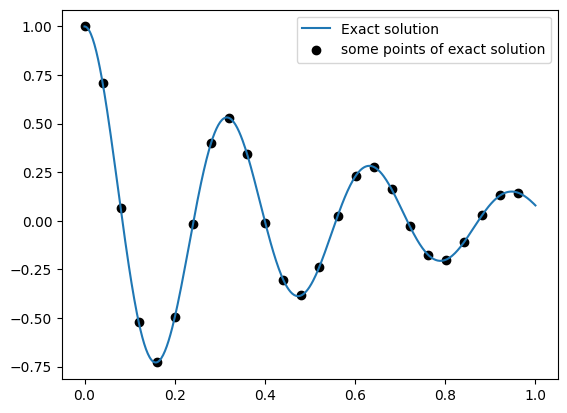

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:500:20]
y_data = y[0:500:20]
print(x_data.shape, y_data.shape)

# Convert tensors to NumPy arrays for plotting
x_np = x.numpy()
y_np = y.numpy()
x_data_np = x_data.numpy()
y_data_np = y_data.numpy()

# Plot
plt.figure()
plt.plot(x_np, y_np, label="Exact solution")  # Usar arrays NumPy
plt.scatter(x_data_np, y_data_np, color="black", label="some points of exact solution")  # Usar arrays NumPy
plt.legend()
plt.show()

In [5]:
# Plot function
def plot_result(x, y, x_data, y_data, y_pred, xp=None, i=0):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))

    # Convert PyTorch tensor for NumPy, detaching from the computation graph
    x_np = x.detach().numpy()
    y_np = y.detach().numpy()
    x_data_np = x_data.detach().numpy()
    y_data_np = y_data.detach().numpy()
    ypred_np = y_pred.detach().numpy()

    if xp is not None:
        xp_np = xp.detach().numpy()
    else:
        xp_np = None

    # Plot
    plt.plot(x_np, y_np, color="grey", linewidth=2, alpha=0.8, label="Solução Analítica")
    plt.plot(x_np, ypred_np, color="tab:blue", linewidth=4, alpha=0.8, label="Predição da Rede Neural")
    plt.scatter(x_data_np[0], y_data_np[0], s=60, color="black", alpha=0.4, label='Condição Inicial')
    if xp_np is not None:
        plt.scatter(xp_np, -0 * np.ones_like(xp_np), s=60, color="tab:green", alpha=0.4,
                    label='Locais de treino da Physics loss')
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" % (i + 1), fontsize="xx-large", color="k")
    plt.axis()



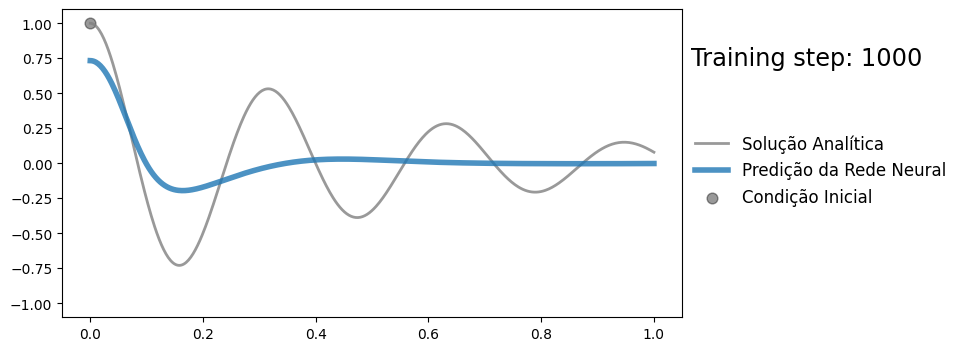

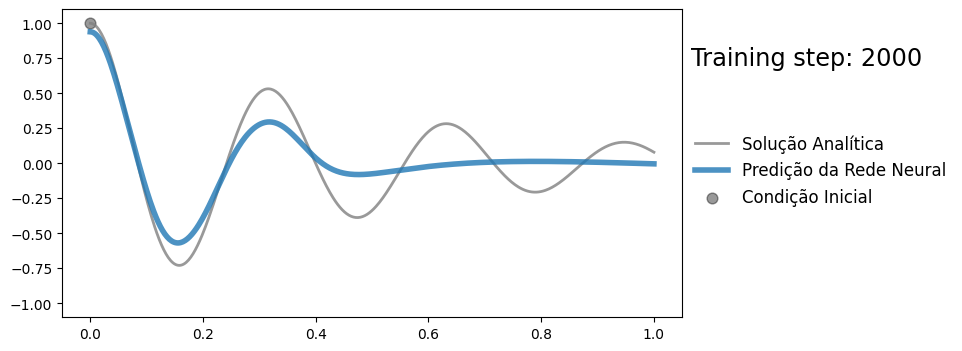

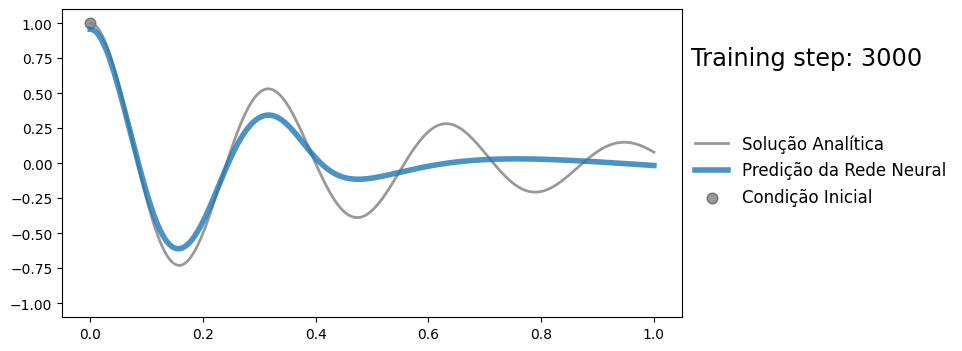

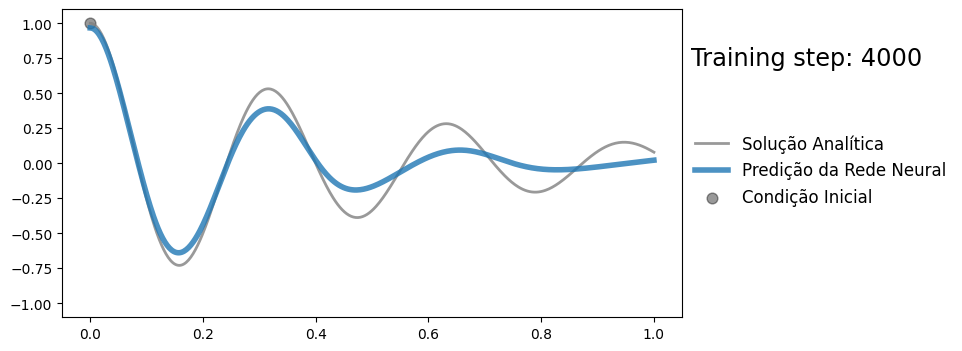

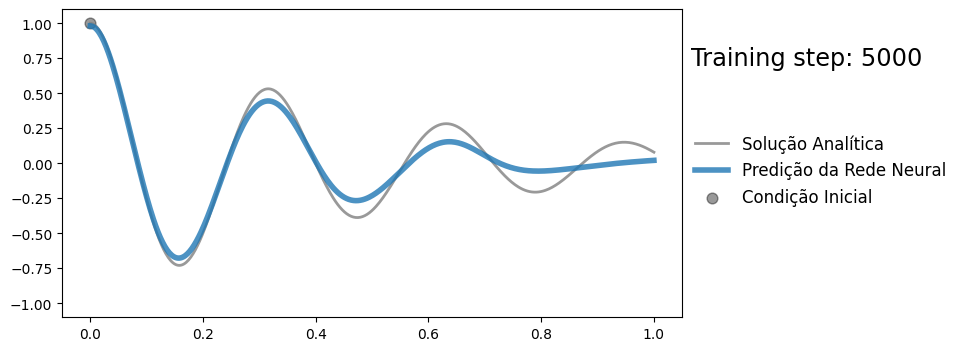

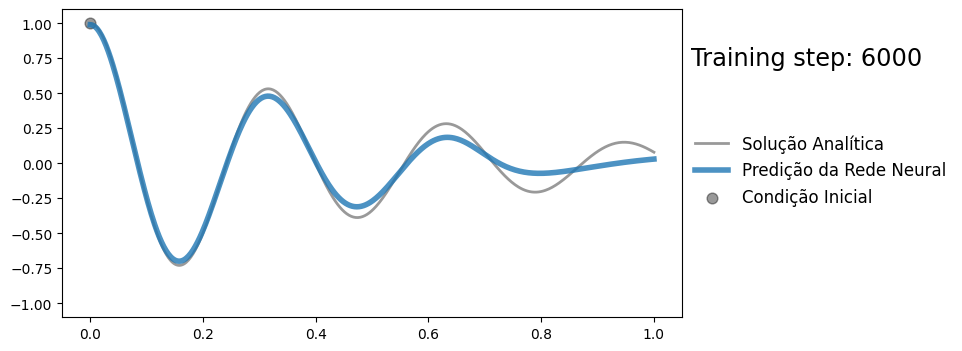

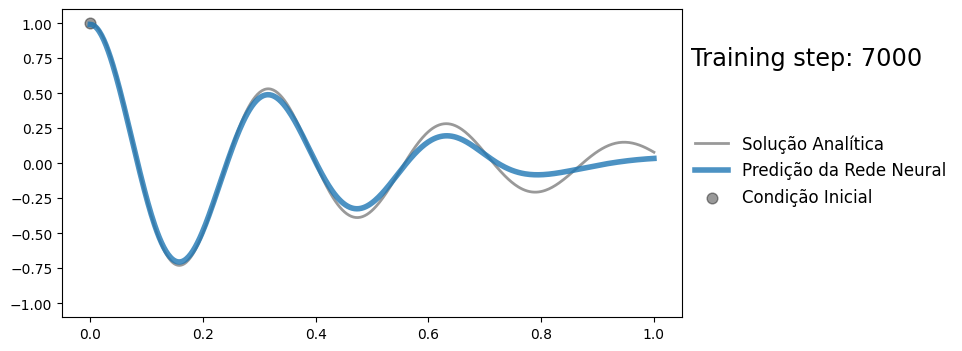

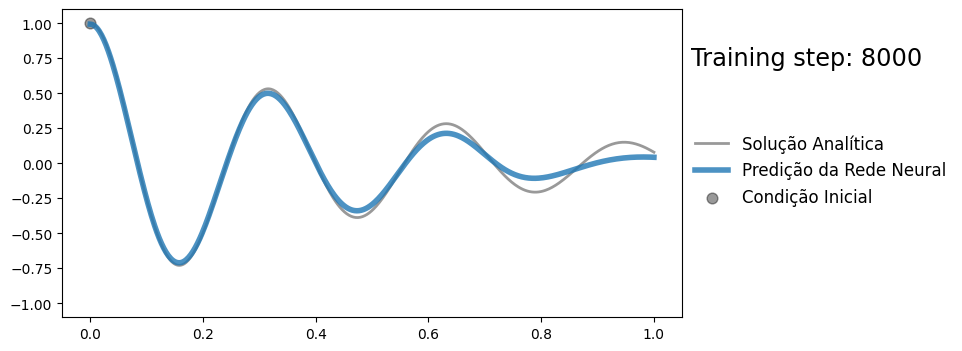

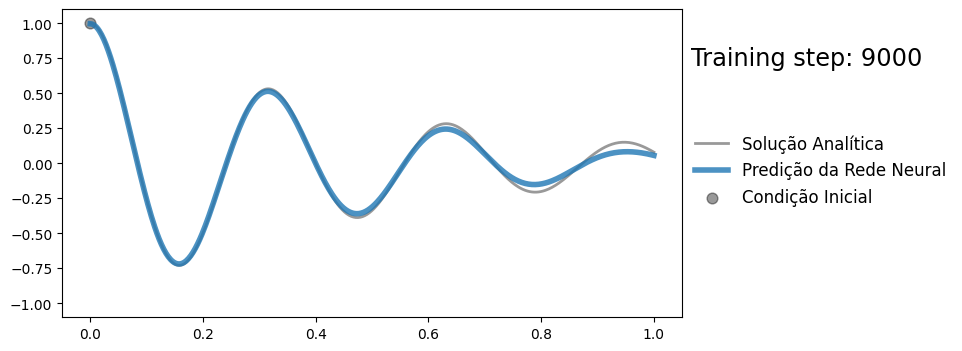

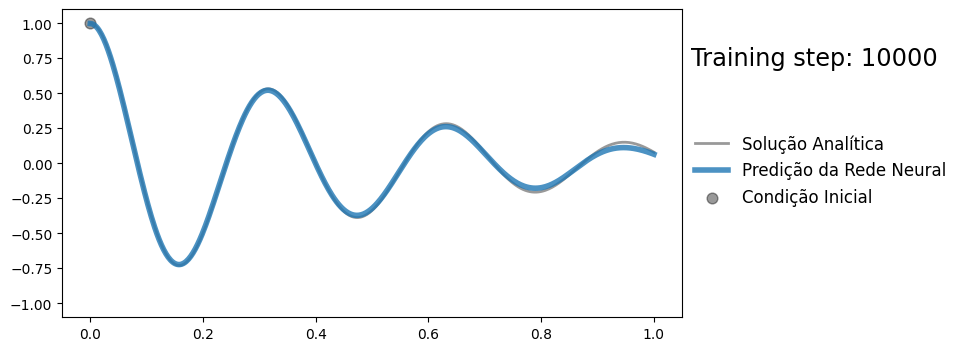

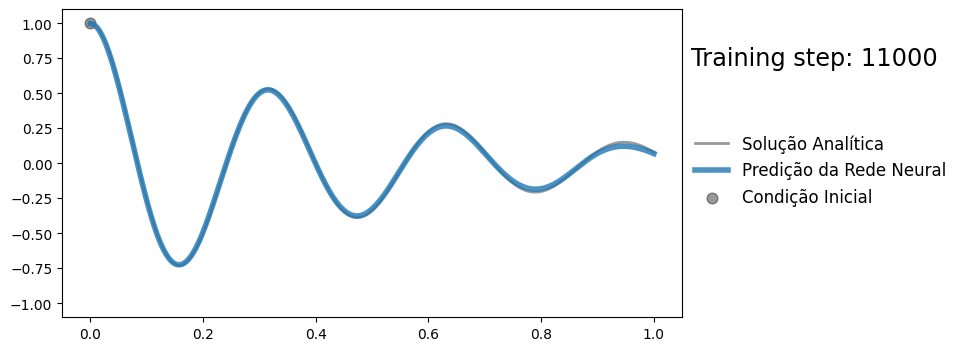

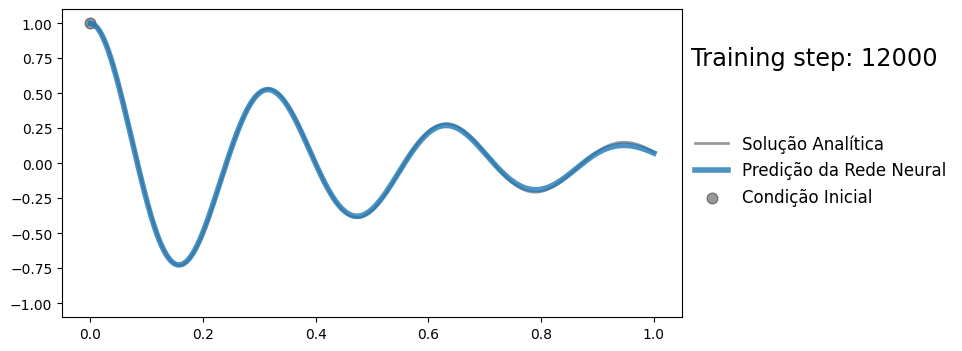

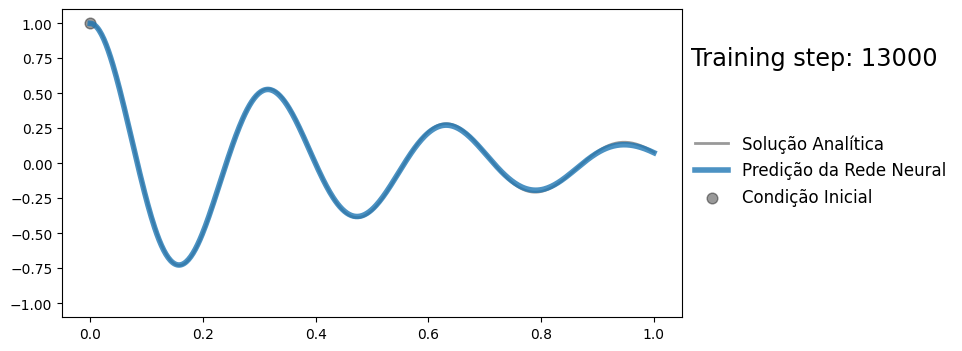

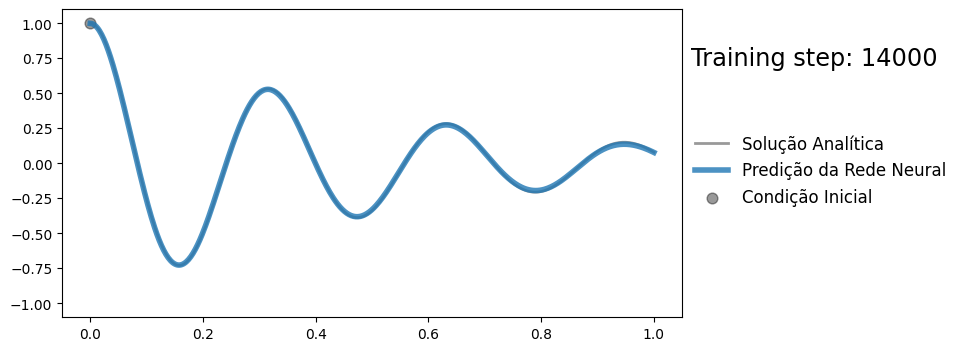

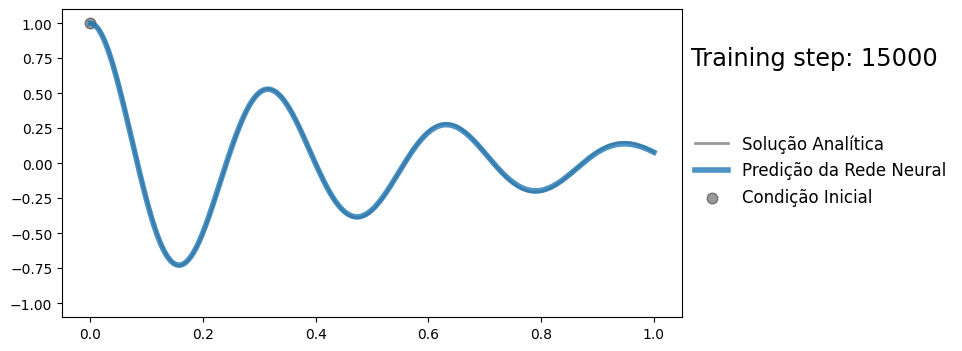

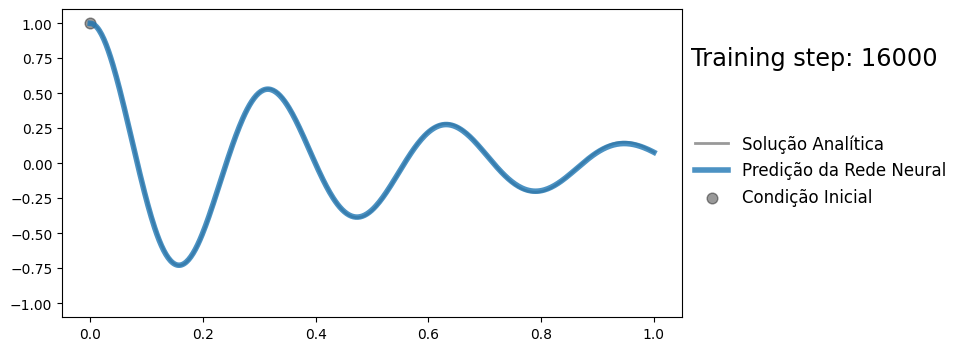

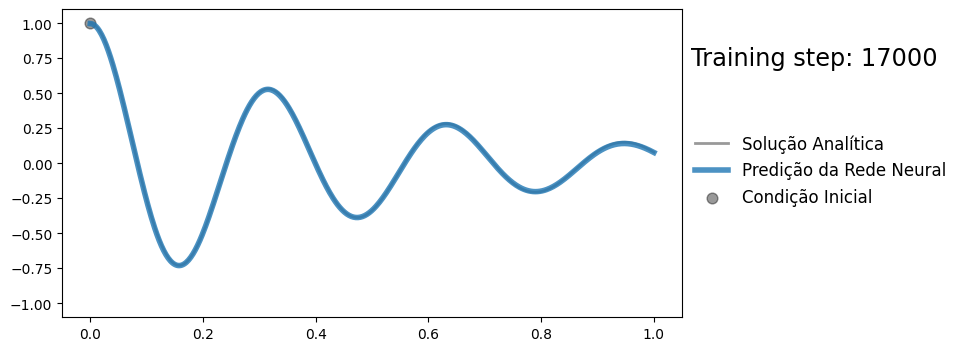

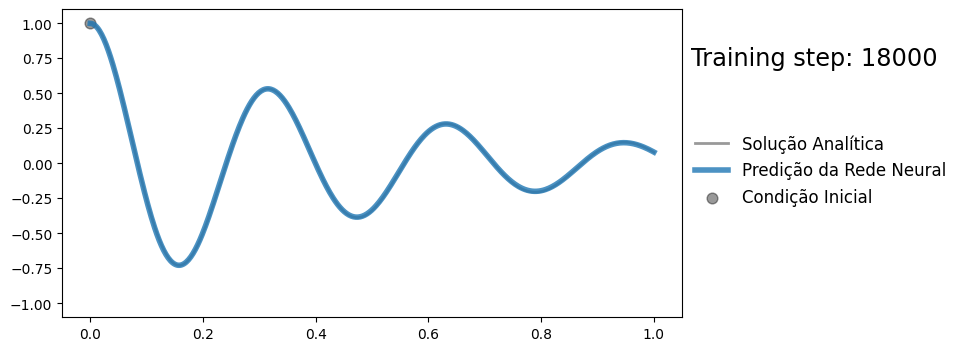

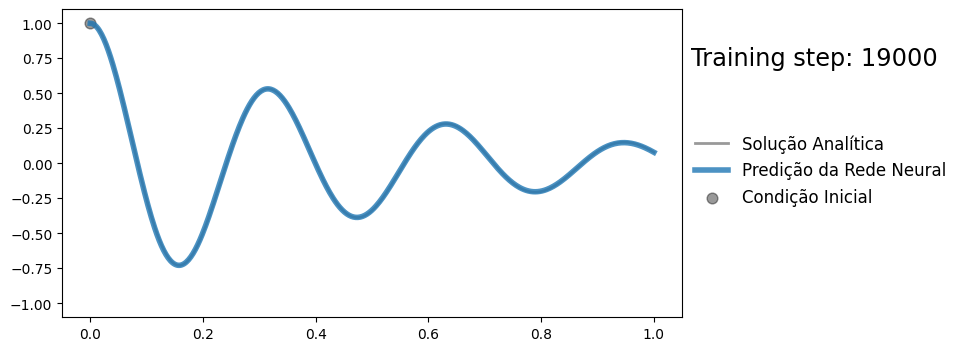

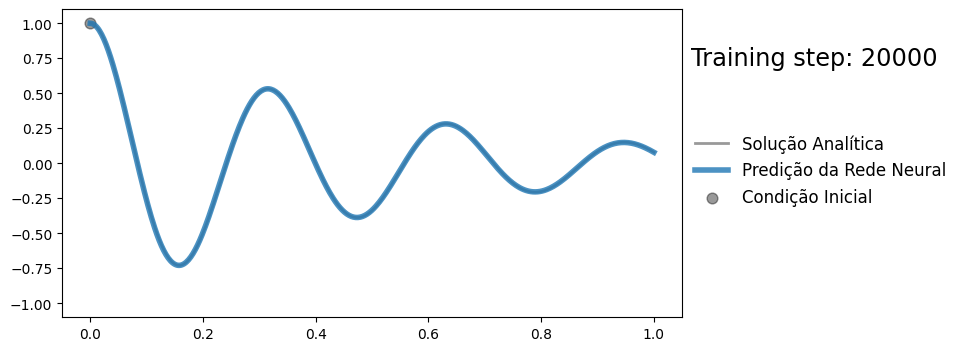

In [6]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

# Instanciando o modelo
model = PhysicsInformedNN()

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Definindo os dados iniciais
x0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)  # Ponto inicial x=0
y0 = torch.tensor([1.0], dtype=torch.float32)  # Condição inicial: y(0) = 1
v0 = torch.tensor([0.0], dtype=torch.float32)  # Condição inicial: dy/dx(0) = 0

files = []

# Treinamento
for epoch in range(20000):  # Número de iterações
    optimizer.zero_grad()

    # Gerar amostras aleatórias no domínio para a equação diferencial
    x = torch.linspace(0, 1, 500).view(-1, 1)  # 500 pontos
    x.requires_grad_(True)

    # Previsão da rede neural
    y_pred = model(x_physics)

    # Cálculo das derivadas
    dy_dx = torch.autograd.grad(y_pred, x_physics, torch.ones_like(y_pred), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]

    # Perda física
    physics = d2y_dx2 + mu*dy_dx + k*y_pred
    loss_physics = (1e-4)*torch.mean(physics**2)

    # Perda de condições iniciais
    y_pred_0 = model(x0)
    dy_dx_0 = torch.autograd.grad(y_pred_0, x0, torch.ones_like(y_pred_0), create_graph=True)[0]
    loss_initial = torch.mean((y_pred_0 - y0)**2) + torch.mean((dy_dx_0 - v0)**2)

    # Perda total
    loss_total = loss_physics + loss_initial

    # Backpropagation e otimização
    loss_total.backward()
    optimizer.step()
    # Plot the result as training progresses

    if (epoch + 1) % 500 == 0:
      yh = model(x).detach()  # Get the predictions from the model

      plot_result(x, y, x_data, y_data, yh, i=epoch)  # Plot the result

      file = os.path.join(output_dir, "pinn_%.8i.png" % (epoch + 1))
      plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")  # Save the plot
      files.append(file)  # Store the file name in the list

      # Show or close plot depending on the iteration
      if (epoch + 1) % 1000 == 0:
          plt.show()
      else:
          plt.close("all")

      if epoch % 1000 == 0:
          print(f"Epoch {epoch}: Loss = {loss_total.item():.6f}")


GIF salvo em: /home/ppavoleti/Documents/Ufscar/TCC/plots/pinn.gif


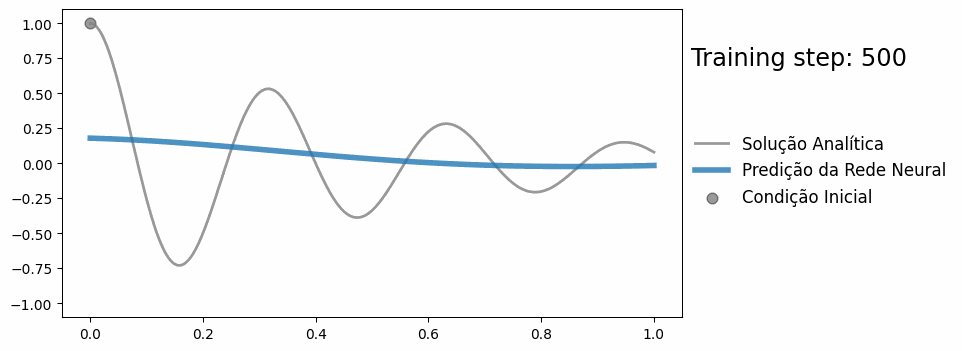

In [8]:
from IPython.display import Image as IPImage, display


gif_path = os.path.join(output_dir, "pinn.gif")  # # Path of the generated GIF
save_gif_PIL(gif_path, files, fps=2010, loop=0)  # Save GIF
print("GIF salvo em:", gif_path)  # For conference

# Show animated GIF in Colab
display(IPImage(gif_path))